# Distribution-abundance Train and Test (AIM+ABR -> AIM)

**Written by Timm Nawrocki**

*Last updated Saturday, October 22, 2018.*

In [1]:
# -*- coding: utf-8 -*-
# ---------------------------------------------------------------------------
# Distribution-abundance Train and Test
# Author: Timm Nawrocki, Alaska Center for Conservation Science
# Created on: 2018-10-22
# Usage: Must be executed as a Jupyter Notebook in an Anaconda 3 installation.
# Description: "Distribution-Abundance Train and Test" trains a classifier to predict species presence and absence and trains a regressor to predict species abundance within areas of predicted presence. The predictions are composited into a single continuous output that can theoretically range from 0 to 100 representing percent cover. All model performance metrics are calculated on independent test partitions.
# ---------------------------------------------------------------------------

## 1. Introduction

This script runs the model train and test steps to output a model performance and variable importance report, trained classifier file, trained regressor file, and threshold files that can be transferred to the predict script. The script is formatted as a Jupyter Notebook and is intended to be run on a Google Cloud virtual machine with 2 vCPUs and 13 GB of CPU memory with an Ubuntu operating system (18.04 LTS). The classifier and regressor in this script are set to use 1 core to provide the most cost efficient, rather than the fastest, model fit and prediction. For information on generating inputs for this script or on setting up Google Cloud virtual machines, see the [project readme](https://github.com/accs-uaa/vegetation-cover-modeling).

The distribution and abundance of a species is two distinct problems: 1. Where does the species occur? 2. Where the species occurs, how much is present? To represent the nested nature of the problems, we developed a hierarchical model where a classifier predicted species presence-absence and a regressor predicted species abundance in areas of predicted species presence. The practical advantage to this hierarchical method is that it accurately predicts zeros (i.e., absences), which are of disproportionate ecological value than exact prediction of other values along the gradient.

## 2. Import Data and Variables

This script relies on data that has been pre-processed into a csv file using the "Format Taxon Data" ArcGIS Pro script tool. The csv file must include all presence and absence observations for the target taxon or aggregate and all values for features extracted to the site locations. Features defined below must be modified to match the input csv file if changes to the construction of features are made.

In [2]:
# Define input file
input_file = 'E:/VegetationEcology/Data_Harmonization/Project_GIS/Data_Output/speciesData/salix_pulchra.csv'
# Define output folder
output_folder = 'E:/VegetationEcology/Data_Harmonization/Project_GIS/Data_Output/modelResults/test_quant/'
# Define output report
output_report_name = 'salix-pulchra-report.html'
# Define species, genera, or aggregate name
taxon_name = 'Salix pulchra'

In [3]:
# Define variable sets
predictor_all = ['compoundTopographic', 'dateFreeze_2000s', 'dateThaw_2000s', 'elevation', 'floodplainsDist', 'growingSeason_2000s', 'heatLoad', 'integratedMoisture', 'precipAnnual_2000s', 'roughness', 'siteExposure', 'slope', 'streamLargeDist', 'streamSmallDist', 'summerWarmth_2000s', 'surfaceArea', 'surfaceRelief', 'aspect', 'may_1_ultraBlue', 'may_2_blue', 'may_3_green', 'may_4_red', 'may_5_nearInfrared', 'may_6_shortInfrared1', 'may_7_shortInfrared2', 'may_evi2', 'may_nbr', 'may_ndmi', 'may_ndsi', 'may_ndvi', 'may_ndwi', 'june_1_ultraBlue', 'june_2_blue', 'june_3_green', 'june_4_red', 'june_5_nearInfrared', 'june_6_shortInfrared1', 'june_7_shortInfrared2', 'june_evi2', 'june_nbr', 'june_ndmi', 'june_ndsi', 'june_ndvi', 'june_ndwi', 'july_1_ultraBlue', 'july_2_blue', 'july_3_green', 'july_4_red', 'july_5_nearInfrared', 'july_6_shortInfrared1', 'july_7_shortInfrared2', 'july_evi2', 'july_nbr', 'july_ndmi', 'july_ndsi', 'july_ndvi', 'july_ndwi', 'august_1_ultraBlue', 'august_2_blue', 'august_3_green', 'august_4_red', 'august_5_nearInfrared', 'august_6_shortInfrared1', 'august_7_shortInfrared2', 'august_evi2', 'august_nbr', 'august_ndmi', 'august_ndsi', 'august_ndvi', 'august_ndwi', 'september_1_ultraBlue', 'september_2_blue', 'september_3_green', 'september_4_red', 'september_5_nearInfrared', 'september_6_shortInfrared1', 'september_7_shortInfrared2', 'september_evi2', 'september_nbr', 'september_ndmi', 'september_ndsi', 'september_ndvi', 'september_ndwi']
zero_variable = ['zero']
strata = ['strata']
cover = ['cover']
retain_variables = ['project', 'siteID', 'siteCode', 'methodSurvey', 'methodCover', 'plotDimensions', 'vascularScope', 'nonvascularScope', 'lichenScope', 'date', 'datum', 'latitude', 'longitude', 'ten', 'twentyfive']
coordinates = ['POINT_X', 'POINT_Y']
all_variables = retain_variables + coordinates + predictor_all + zero_variable + strata + cover
iteration = ['iteration']
absence = ['absence']
presence = ['presence']
response = ['response']
prediction = ['prediction']
output_variables = all_variables + iteration + absence + presence + response + prediction

## 3. Initialize

This script has general dependencies on the *os* package for file system manipulations, the *numpy* and *pandas* packages for data manipulations, and the *seaborn* and *matplotlib* packages for plotting. *GPy* and *GPyOpt* are Gaussian Process packages that drive the bayesian optimization of hyperparameters. *XGBoost* provides the gradient boosting classifier and regressor used to create the composite predictions. *Scikit Learn* provides a random forest classifier and regressor for comparison to the gradient boosting performance, model selection and cross validation tools, performance metrics, and a function to save models.

In [4]:
# Import packages for file manipulation, data manipulation, and plotting
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plot
# Import module for altering output display
from IPython.display import clear_output
# Import packages for bayesian optimization
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
# Import XGBoost gradient boosting implementations
from xgboost import XGBClassifier
from xgboost import XGBRegressor
# Import modules for model selection, cross validation, random forest, and performance from Scikit Learn
from sklearn.utils import shuffle
from sklearn.feature_selection import RFECV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.externals import joblib

In [5]:
# Create a plots folder if it does not exist
plots_folder = os.path.join(output_folder, "plots")
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

In [6]:
# Define output test data
output_csv = os.path.join(output_folder, 'prediction.csv')
# Define output model files
output_classifier = os.path.join(output_folder, 'classifier.joblib')
output_regressor = os.path.join(output_folder, 'regressor.joblib')
# Define output threshold file
threshold_file = os.path.join(output_folder, 'threshold.txt')
# Define threshold and metrics table
metrics_file = os.path.join(output_folder, 'metrics.csv')
# Define output feature elimination plots
classifier_feature_file = os.path.join(plots_folder, "classifier_feature_elimination.png")
regressor_feature_file = os.path.join(plots_folder, "regressor_feature_elimination.png")
# Define output correlation plot
variable_correlation = os.path.join(plots_folder, "variable_correlation.png")
# Define output variable importance plots
importance_classifier = os.path.join(plots_folder, "importance_classifier.png")
importance_regressor = os.path.join(plots_folder, "importance_regressor.png")
# Define output bayesian optimization convergence plots
convergence_classifier = os.path.join(plots_folder, "convergence_classifier.png")
convergence_regressor = os.path.join(plots_folder, "convergence_regressor.png")

## 4. Functions

Analyses are conducted in units represented by functions. The functions are defined below in order of use. In general, functions in this script fall into three categories: Bayesian Optimization, Train and Test Iteration, and Export Results.

### 4.1. Bayesian Optimization Functions

In [7]:
# Define an optimization objective function for the xgboost classifier
def cvClassifier(parameters):
    # Define the search parameter set
    parameters = parameters[0]
    # Create a cross validation split method with 10 splits
    cv_splits = ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.7, random_state=None)
    # Define the cross validator
    score = cross_val_score(
        XGBClassifier(max_depth=int(parameters[0]),
                     learning_rate=parameters[1],
                     n_estimators=int(parameters[2]),
                     silent=True,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=1,
                     gamma=parameters[3],
                     min_child_weight=int(parameters[4]),
                     max_delta_step=int(parameters[5]),
                     subsample=parameters[6],
                     colsample_bytree=parameters[7],
                     colsample_bylevel=parameters[8],
                     reg_alpha=parameters[9],
                     reg_lambda=parameters[10],
                     scale_pos_weight=parameters[11]),
        X, y, scoring='roc_auc', cv=cv_splits).mean()
    # Convert the mean score to array and return the inverse of the array for minimization
    score = np.array(score)
    return -score

In [8]:
# Define an optimization objective function for the xgboost regressor
def cvRegressor(parameters):
    # Define the search parameter set
    parameters = parameters[0]
    # Create a cross validation split method with 100 splits
    cv_splits = ShuffleSplit(n_splits=100, test_size=0.3, train_size=0.7, random_state=None)
    # Define the cross validator
    score = cross_val_score(
        XGBRegressor(max_depth=int(parameters[0]),
                     learning_rate=parameters[1],
                     n_estimators=int(parameters[2]),
                     silent=True,
                     objective='reg:linear',
                     booster='gbtree',
                     n_jobs=1,
                     gamma=parameters[3],
                     min_child_weight=int(parameters[4]),
                     max_delta_step=int(parameters[5]),
                     subsample=parameters[6],
                     colsample_bytree=parameters[7],
                     colsample_bylevel=parameters[8],
                     reg_alpha=parameters[9],
                     reg_lambda=parameters[10],
                     scale_pos_weight=parameters[11]),
        X, y, scoring='r2', cv=cv_splits).mean()
    # Convert the mean score to array and return the inverse of the array for minimization
    score = np.array(score)
    return -score

In [9]:
# Define an optimization function
def bayesianOptimizer(objective_function, X, y, plot_file):
    # Create the hyperparameter search domain
    domain=[{'name': 'max_depth', 'type': 'discrete', 'domain': (3, 10)},
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'n_estimators', 'type': 'discrete', 'domain': (500, 5000)},
            {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
            {'name': 'min_child_weight', 'type': 'discrete', 'domain': (0, 10)},
            {'name': 'max_delta_step', 'type': 'continuous', 'domain': (0, 5)},
            {'name': 'subsample', 'type': 'continuous', 'domain': (0.5, 1)},
            {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0.3, 1)},
            {'name': 'colsample_bylevel', 'type': 'continuous', 'domain': (0.3, 1)},
            {'name': 'reg_alpha', 'type': 'continuous', 'domain': (0, 10)},
            {'name': 'reg_lamda', 'type': 'continuous', 'domain': (0, 10)},
            {'name': 'scale_pos_weight', 'type': 'continuous', 'domain': (0, 5)}]
    # Initialize the Bayesian Optimizer
    optimizer = BayesianOptimization(f=objective_function,
                                     domain=domain,
                                     model_type='GP',
                                     initial_design_numdata=50,
                                     initial_design_type='random',
                                     acquisition_type ='EI',
                                     exact_feval=False,
                                     maximize=False)
    # Run 250 iterations of optimization
    optimizer.run_optimization(max_iter=250)
    # Plot the convergence of the best solution
    optimizer.plot_convergence(filename=plot_file)
    # Return results
    return optimizer

### 4.2. Train and Test Iteration Functions

In [10]:
# Create a function to create the train and test partitions
def partitionData(inData, all_variables, predictors, response, strata):
    # Create train and test splits
    X = inData[all_variables]
    y = inData[response[0]]
    stratify = inData[strata[0]]
    all_train, all_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size = 0.3,
                                                            train_size = 0.7,
                                                            random_state = None,
                                                            shuffle = True,
                                                            stratify = stratify)
    # Reset the index on the train and test splits
    all_train = all_train.reset_index()
    all_test = all_test.reset_index()
    return all_train, all_test

In [11]:
# Create a function to train a classifier on the train X and y and predict the test X
def trainPredictClassifier(train, test, predictors, response, parameters):
    # Define X and y
    X_train = train[predictors]
    y_train = train[response[0]]
    X_test = test[predictors]
    # Fit a classifier to the train X and y
    classifier = XGBClassifier(max_depth=int(parameters[0]),
                               learning_rate=parameters[1],
                               n_estimators=int(parameters[2]),
                               silent=True,
                               objective='binary:logistic',
                               booster='gbtree',
                               n_jobs=1,
                               gamma=parameters[3],
                               min_child_weight=int(parameters[4]),
                               max_delta_step=int(parameters[5]),
                               subsample=parameters[6],
                               colsample_bytree=parameters[7],
                               colsample_bylevel=parameters[8],
                               reg_alpha=parameters[9],
                               reg_lambda=parameters[10],
                               scale_pos_weight=parameters[11])
    classifier.fit(X_train, y_train)
    # Use the classifier to predict class probabilities
    prediction = classifier.predict_proba(X_test)
    # Concatenate predicted values to test data frame
    test = pd.concat([test, pd.DataFrame(prediction)], axis=1)
    test = test.rename(index=int, columns={0: 'absence', 1: 'presence'})
    # Return the predictions
    return test

In [12]:
# Create a function to train a regressor on the train X and y and predict the test X
def trainPredictRegressor(train, test, predictors, response, parameters):
    # Define X and y
    X_train = train[predictors]
    y_train = train[response[0]]
    X_test = test[predictors]
    # Fit a regressor to the train X and y
    regressor = XGBRegressor(max_depth=int(parameters[0]),
                             learning_rate=parameters[1],
                             n_estimators=int(parameters[2]),
                             silent=True,
                             objective='reg:linear',
                             booster='gbtree',
                             n_jobs=1,
                             gamma=parameters[3],
                             min_child_weight=int(parameters[4]),
                             max_delta_step=int(parameters[5]),
                             subsample=parameters[6],
                             colsample_bytree=parameters[7],
                             colsample_bylevel=parameters[8],
                             reg_alpha=parameters[9],
                             reg_lambda=parameters[10],
                             scale_pos_weight=parameters[11])
    regressor.fit(X_train, y_train)
    # Use the regressor to predict response values
    prediction = regressor.predict(X_test)
    # Concatenate predicted values to test data frame
    test = pd.concat([test, pd.DataFrame(prediction)], axis=1)
    test = test.rename(index=int, columns={0: 'response'})
    # Return the predictions
    return test

In [13]:
# Define a function to calculate performance metrics based on a specified threshold value
def testPresenceThreshold(predict_probability, threshold, y_test):
    # Create an empty array of zeroes that matches the length of the probability predictions
    predict_thresholded = np.zeros(predict_probability.shape)
    # Set values for all probabilities greater than or equal to the threshold equal to 1
    predict_thresholded[predict_probability >= threshold] = 1
    # Determine error rates
    confusion_test = confusion_matrix(y_test, predict_thresholded)
    true_negative = confusion_test[0,0]
    false_negative = confusion_test[1,0]
    true_positive = confusion_test[1,1]
    false_positive = confusion_test[0,1]
    # Calculate sensitivity and specificity
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    # Calculate AUC score
    auc = roc_auc_score(y_test, predict_probability)
    # Calculate overall accuracy
    accuracy = (true_negative + true_positive) / (true_negative + false_positive + false_negative + true_positive)
    # Return the thresholded probabilities and the performance metrics
    return (sensitivity, specificity, auc, accuracy)

In [14]:
# Create a function to determine a presence threshold
def determineOptimalThreshold(predict_probability, y_test):
    # Iterate through numbers between 0 and 1000 to output a list of sensitivity and specificity values per threshold number
    i = 1
    sensitivity_list = []
    specificity_list = []
    while i < 1001:
        threshold = i/1000
        sensitivity, specificity, auc, accuracy = testPresenceThreshold(predict_probability, threshold, y_test)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        i = i + 1
    # Calculate a list of absolute value difference between sensitivity and specificity and find the optimal threshold
    difference_list = [np.absolute(a - b) for a, b in zip(sensitivity_list, specificity_list)]
    value, threshold = min((value, threshold) for (threshold, value) in enumerate(difference_list))
    threshold = threshold/1000
    # Calculate the performance of the optimal threshold
    sensitivity, specificity, auc, accuracy = testPresenceThreshold(predict_probability, threshold, y_test)
    # Return the optimal threshold and the performance metrics of the optimal threshold
    return threshold, sensitivity, specificity, auc, accuracy

In [15]:
# Create a function to composite model results
def compositePrediction(test, presence, response, threshold):
    # Define a function to threshold absences and set presences equal to regression response
    def compositeRows(row):
        if row[presence[0]] < threshold:
            return 0
        elif row[presence[0]] >= threshold:
            return row[response[0]]
    # Apply function to all rows in test data
    test['prediction'] = test.apply(lambda row: compositeRows(row), axis=1)
    # Return the test data frame with composited results
    return test

In [16]:
# Create a function to calculate pseudo r-squared and RMSE for the composited prediction
def calculatePerformance(test, cover, prediction):
    # Define the true values and the predicted values for the response variable
    y_test = test[cover[0]]
    y_prediction = test[prediction[0]]
    # Calculate pseudo r-squared
    r_score = r2_score(y_test, y_prediction, sample_weight=None, multioutput='uniform_average')
    # Calculate error
    mae = mean_absolute_error(y_test, y_prediction)
    rmse = np.sqrt(mean_squared_error(y_test, y_prediction))
    # Return performance metrics
    return r_score, mae, rmse

### 4.3. Export Results Functions

In [17]:
# Plot the results of the recursive feature eliminator for the classifier
def plotFeatureElimination(feature_eliminator, y_label, feature_plot_file):
    feature_plot = plot.figure()
    fig_size = plot.rcParams["figure.figsize"]
    fig_size[0] = 8
    fig_size[1] = 6
    plot.rcParams["figure.figsize"] = fig_size
    plot.xlabel("Number of features selected")
    plot.ylabel(y_label)
    plot.plot(range(1, len(feature_eliminator.grid_scores_) + 1), feature_eliminator.grid_scores_)
    plot.show()
    feature_plot.savefig(feature_plot_file, bbox_inches="tight", dpi=300)
    # Clear plot workspace
    plot.clf()
    plot.close()

In [18]:
# Define a function to plot Pearson correlation of predictor variables
def plotVariableCorrelation(X_train, outFile):
    # Calculate Pearson correlation coefficient between the predictor variables, where -1 is perfect negative correlation and 1 is perfect positive correlation
    correlation = X_train.astype('float64').corr()
    # Generate a mask for the upper triangle of plot
    mask = np.zeros_like(correlation, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plot.subplots(figsize=(20, 18))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    correlation_plot = sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})
    correlation_figure = correlation_plot.get_figure()
    correlation_figure.savefig(outFile, bbox_inches='tight', dpi=300)
    # Clear plot workspace
    plot.clf()
    plot.close()

In [19]:
# Define a function to plot variable importances
def plotVariableImportances(inModel, X_train, outVariableFile):
    # Get numerical feature importances
    importances = list(inModel.feature_importances_)
    # List of tuples with variable and importance
    feature_list = list(X_train.columns)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Initialize the plot and set figure size
    variable_figure = plot.figure()
    fig_size = plot.rcParams["figure.figsize"]
    fig_size[0] = 18
    fig_size[1] = 6
    plot.rcParams["figure.figsize"] = fig_size
    # Create list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart of the variable importances
    plot.bar(x_values, importances, orientation = 'vertical')
    # Tick labels for x axis
    plot.xticks(x_values, feature_list, rotation='vertical')
    # Axis labels and title
    plot.ylabel('Importance'); plot.xlabel('Variable'); plot.title('Variable Importances');
    # Export
    variable_figure.savefig(outVariableFile, bbox_inches="tight", dpi=300)
    # Clear plot workspace
    plot.clf()
    plot.close()

In [20]:
# Create a function to train and export a classifier
def trainExportClassifier(input_data, predictors, response, parameters, outModel, outImportance):
    # Define the predictor labels (X) and the response label (y) in the input dataframe
    X = input_data[predictors]
    y = input_data[response[0]]
    # Fit a classifier to the input dataset
    classifier = XGBClassifier(max_depth=int(parameters[0]),
                               learning_rate=parameters[1],
                               n_estimators=int(parameters[2]),
                               silent=True,
                               objective='binary:logistic',
                               booster='gbtree',
                               n_jobs=1,
                               gamma=parameters[3],
                               min_child_weight=int(parameters[4]),
                               max_delta_step=int(parameters[5]),
                               subsample=parameters[6],
                               colsample_bytree=parameters[7],
                               colsample_bylevel=parameters[8],
                               reg_alpha=parameters[9],
                               reg_lambda=parameters[10],
                               scale_pos_weight=parameters[11])
    classifier.fit(X, y)
    # Save classifier to an external file
    joblib.dump(classifier, outModel)
    # Export a variable importance plot
    plotVariableImportances(classifier, X, outImportance)

In [21]:
def trainExportRegressor(input_data, predictors, response, parameters, outModel, outImportance):
    # Define the predictor labels (X) and the response label (y) in the input dataframe
    X = input_data[predictors]
    y = input_data[response[0]]
    # Fit a classifier to the input dataset
    regressor = XGBRegressor(max_depth=int(parameters[0]),
                             learning_rate=parameters[1],
                             n_estimators=int(parameters[2]),
                             silent=True,
                             objective='reg:linear',
                             booster='gbtree',
                             n_jobs=1,
                             gamma=parameters[3],
                             min_child_weight=int(parameters[4]),
                             max_delta_step=int(parameters[5]),
                             subsample=parameters[6],
                             colsample_bytree=parameters[7],
                             colsample_bylevel=parameters[8],
                             reg_alpha=parameters[9],
                             reg_lambda=parameters[10],
                             scale_pos_weight=parameters[11])
    regressor.fit(X, y)
    # Save classifier to an external file
    joblib.dump(regressor, outModel)
    # Export a variable importance plot
    plotVariableImportances(regressor, X, outImportance)

## 5. Conduct Analyses

The analyses are subdivided into subsections: load data, assess untuned model performance, recursive feature elimination, bayesian optimization, train and test iterations, and export results. The majority of analytical time is devoted to recursive feature elimination and bayesian optimization to ensure selection of a best performing model. The XGBoost implementation of stochastic gradient boosting is the primary algorithm. Random forest is included in the assessment of untuned model performance for comparison with stochastic gradient boosting.

The optimal feature set and hyperparameters are passed into 100 iterations of training and testing in which the results of the classifier and regressor are composited to determine overall performance. For each iteration, we withhold 30% of the data at random stratified by broad cover ranges as an independent test partition. The composited prediction results are appended into a single data frame for additional analyses and plotting external to this script.

Outputs of the analysis are:
1. Report of performance, including the following plots:
  1. Recursive feature elimination for the classifier
  2. Recursive feature elimination for the regressor
  3. Convergence of the classifier hyperparameters
  4. Convergence of the regressor hyperparameters
  5. Variable importances of the classifier
  6. Variable importances of the regressor
  7. Pearson correlation for all predictors
2. Model files:
  1. Classifier
  2. Regressor
3. Table of performance metrics
4. Mean threshold
5. Test predictions from 100 validation iterations

### 5.1. Load Data

Two data instances were created based on the input csv file: an input data frame and a presence only AIM NPR-A data subset. The presence-absence classifiers were trained from the input data and the abundance regressors were trained from the presence AIM data.

In [22]:
# Create data frame of input data
input_data = pd.read_csv(input_file)
# Convert values to floats
input_data[predictor_all + cover + coordinates] = input_data[predictor_all + cover + coordinates].astype(float)
# Convert values to integers
input_data[strata + zero_variable] = input_data[strata + zero_variable].astype(int)
# Restrict data to AIM and ABR samples only
aim_data = input_data[input_data['project'] == 'AIM NPR-A']
abr_data = input_data[input_data['project'] == 'ABR Shell']
input_data = aim_data.append(abr_data, ignore_index=True, sort=True)
# Shuffle data
input_data = shuffle(input_data)

In [23]:
# Subset the training data to presences from AIM NPR-A
presence_data = input_data[input_data[cover[0]] >= 1]
presence_data = presence_data[presence_data['project'] == 'AIM NPR-A']

In [24]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plot.rcParams["figure.figsize"] = fig_size
plot.style.use('grayscale')

### 5.2. Assess untuned model performance

For comparison, the untuned performance of a gradient boosting and random forest classifier and regressor are assessed by shuffle split cross validation. The performance of the final model should be comparable to or better than the performance of the untuned models. The performance of the classifier has low variance and is therefore cross validated with only 10 iterations. The test split is retained at 30% of the data for all cross validation and test purposes in this script. The performance of the regressor has high variance, likely derived from the low sample size, and is therefore cross validated with 100 iterations.

#### 5.2.1. Untuned classifier performance

In [25]:
# Define a cross validation split method
cv_splits_classifier = ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.7, random_state=None)

In [26]:
# Split the X and y data
X = input_data[predictor_all]
y = input_data[zero_variable[0]]
# Shuffle data
X, y = shuffle(X, y)

In [27]:
# Create a random forest classifier with 5000 trees
rfClassifier = RandomForestClassifier(n_estimators=5000,
                                      criterion='entropy',
                                      max_features='log2',
                                      bootstrap=True,
                                      oob_score=False,
                                      n_jobs=1,
                                      class_weight='balanced')
# Test the performance of the random forest classifier using 5-fold cross validation
baseline_rfClassifier = cross_val_score(rfClassifier, X, y, scoring='roc_auc', cv=cv_splits_classifier)

In [28]:
# Display the mean and standard deviation of AUC for the random forest classifier
print(baseline_rfClassifier.mean())
print(baseline_rfClassifier.std())

0.7599370058792115
0.02904348259394795


In [29]:
# Create an xgboost classifier with untuned settings
xgbClassifier = XGBClassifier(max_depth=3,
                              learning_rate=0.05,
                              n_estimators=5000,
                              silent=True,
                              objective='binary:logistic',
                              booster='gbtree',
                              n_jobs=1,
                              gamma=3,
                              min_child_weight=2,
                              max_delta_step=1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              colsample_bylevel=0.5,
                              reg_alpha=2,
                              reg_lambda=2,
                              scale_pos_weight=1)
# Test the perfomance of the default xgboost classifier using 5-fold cross validation
baseline_xgbClassifier = cross_val_score(xgbClassifier, X, y, scoring='roc_auc', cv=cv_splits_classifier)

In [30]:
# Display the mean and standard deviation of AUC for the untuned xgboost classifier
print(baseline_xgbClassifier.mean())
print(baseline_xgbClassifier.std())

0.7554727912686965
0.024091951700690603


#### 5.2.2. Untuned regressor performance

In [31]:
# Define a cross validation split method
cv_splits_regressor = ShuffleSplit(n_splits=100, test_size=0.3, train_size=0.7, random_state=None)

In [32]:
# Split the X and y data
X = presence_data[predictor_all]
y = presence_data[cover[0]]
# Shuffle data
X, y = shuffle(X, y)

In [33]:
# Create a random forest regressor with 5000 trees
rfRegressor = RandomForestRegressor(n_estimators=5000,
                                    criterion='mse',
                                    bootstrap=True,
                                    oob_score=False,
                                    n_jobs=1)
# Test the performance of the random forest regressor using 5-fold cross validation
baseline_rfRegressor = cross_val_score(rfRegressor, X, y, scoring='r2', cv=cv_splits_regressor)

In [34]:
# Display the mean and standard deviation of R Squared for the random forest regressor
print(baseline_rfRegressor.mean())
print(baseline_rfRegressor.std())

0.3766610533363248
0.2750946623937113


In [35]:
# Create an xgboost regressor with untuned settings
xgbRegressor = XGBRegressor(max_depth=3,
                            learning_rate=0.05,
                            n_estimators=5000,
                            silent=True,
                            objective='reg:linear',
                            booster='gbtree',
                            n_jobs=1,
                            gamma=3.3,
                            min_child_weight=2,
                            max_delta_step=1,
                            subsample=0.8,
                            colsample_bytree=0.5,
                            colsample_bylevel=0.5,
                            reg_alpha=2,
                            reg_lambda=6,
                            scale_pos_weight=1)
# Test the performance of the default xgboost regressor using 5-fold cross validation
baseline_xgbRegressor = cross_val_score(xgbRegressor, X, y, scoring='r2', cv=cv_splits_regressor)

In [36]:
# Display the mean and standard deviation of R Squared for the untuned xgboost regressor
print(baseline_xgbRegressor.mean())
print(baseline_xgbRegressor.std())

0.3738313966988472
0.16363593177650929


### 5.3. Recursive Feature Elimination

The importance of features vary by species and response type. Some features may be uninformative for some species/response combinations, increasing the noise in the prediction. We used a data-driven approach to reduce the features to the best performing subset by implementing recursive feature selection with cross validation. The classifier features were selected on the maximization of ROC AUC using 10 cross validation splits. The regressor features were selected on the maximization of R Squared using 100 cross validation splits.

#### 5.3.1. Classifier Features

In [37]:
# Define the X and y data
X = input_data[predictor_all]
y = input_data[zero_variable]
# Shuffle data
X, y = shuffle(X, y)

In [38]:
# Define the classifier used to generate variable importances
classifier = XGBClassifier(max_depth=3,
                           learning_rate=0.05,
                           n_estimators=5000,
                           silent=True,
                           objective='binary:logistic',
                           booster='gbtree',
                           n_jobs=1,
                           gamma=3,
                           min_child_weight=2,
                           max_delta_step=1,
                           subsample=0.8,
                           colsample_bytree=0.8,
                           colsample_bylevel=0.5,
                           reg_alpha=2,
                           reg_lambda=2,
                           scale_pos_weight=1)

In [39]:
# Define a recursive feature eliminator for the classifier using shuffled cross validation
recursive_eliminator_classifier = RFECV(estimator=classifier, step=1, cv=cv_splits_classifier, scoring='roc_auc')

In [40]:
# Fit the recursive feature eliminator
recursive_eliminator_classifier.fit(X, y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=0.3, train_size=0.7),
   estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.8, gamma=3, learning_rate=0.02, max_delta_step=1,
       max_depth=10, min_child_weight=2, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2, reg_lambda=2, scale_pos_weight=4.5, seed=None,
       silent=True, subsample=0.8),
   n_jobs=1, scoring='roc_auc', step=1, verbose=0)

In [41]:
# Print optimal number of features for the classifier
print("Optimal number of features : %d" % recursive_eliminator_classifier.n_features_)

Optimal number of features : 65


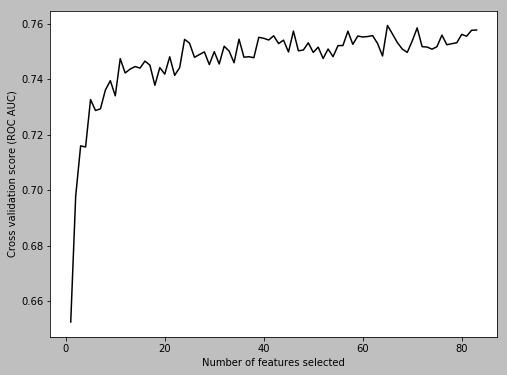

In [42]:
# Plot the results of the recursive feature eliminator for the classifier
y_label = "Cross validation score (ROC AUC)"
plotFeatureElimination(recursive_eliminator_classifier, y_label, classifier_feature_file)

In [43]:
# Select the optimal subset of features for the classifier
classifier_features = pd.DataFrame({'predictor': list(X.columns),
                                    'select': recursive_eliminator_classifier.ranking_.tolist()})
classifier_features = classifier_features.loc[classifier_features['select'] == 1]
classifier_features = classifier_features['predictor'].tolist()

#### 5.3.2. Regressor Features

In [44]:
# Define the X and y data
X = presence_data[predictor_all]
y = presence_data[cover]
# Shuffle data
X, y = shuffle(X, y)

In [45]:
# Define the regressor used to generate variable importances
regressor = XGBRegressor(max_depth=3,
                         learning_rate=0.05,
                         n_estimators=5000,
                         silent=True,
                         objective='reg:linear',
                         booster='gbtree',
                         n_jobs=1,
                         gamma=3.3,
                         min_child_weight=2,
                         max_delta_step=1,
                         subsample=0.8,
                         colsample_bytree=0.5,
                         colsample_bylevel=0.5,
                         reg_alpha=2,
                         reg_lambda=6,
                         scale_pos_weight=1)

In [46]:
# Define a recursive feature eliminator for the regressor using shuffled cross-validation
recursive_eliminator_regressor = RFECV(estimator=regressor, step=1, cv=cv_splits_regressor, scoring='r2')

In [47]:
# Fit the recursive feature eliminator
recursive_eliminator_regressor.fit(X, y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=0.3, train_size=0.7),
   estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=3.3, learning_rate=0.2,
       max_delta_step=1, max_depth=3, min_child_weight=2, missing=None,
       n_estimators=10, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=2, reg_lambda=6, scale_pos_weight=2,
       seed=None, silent=True, subsample=0.8),
   n_jobs=1, scoring='r2', step=1, verbose=0)

In [48]:
# Print optimal number of features for the classifier
print("Optimal number of features : %d" % recursive_eliminator_regressor.n_features_)

Optimal number of features : 53


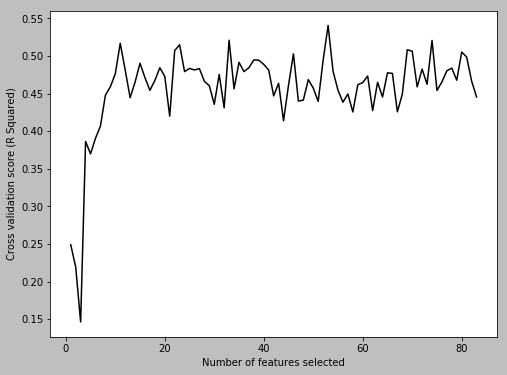

In [49]:
# Plot the results of the recursive feature eliminator for the regressor
y_label = "Cross validation score (R Squared)"
plotFeatureElimination(recursive_eliminator_regressor, y_label, regressor_feature_file)

In [50]:
# Select the optimal subset of features for the regressor
regressor_features = pd.DataFrame({'predictor': list(X.columns),
                                   'select': recursive_eliminator_regressor.ranking_.tolist()})
regressor_features = regressor_features.loc[regressor_features['select'] == 1]
regressor_features = regressor_features['predictor'].tolist()

### 5.4. Bayesian Optimization

We used a Bayesian statistical framework with Gaussian Process as the generative model to find an optimal set of hyperparameters for the classifier and regressor. The Bayesian Optimization tuned species-specific models that make the best generalizations as estimated by cross validation. The domain space for bayesian optimization was large, so we initially sampled 50 points at random and then conducted 250 optimization iterations to converge on a best set of hyperparameters. Optimization occurred independently for the classifier and the regressor.

#### 5.4.1. Classifier optimization

In [51]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 24
fig_size[1] = 12
plot.rcParams["figure.figsize"] = fig_size

In [52]:
# Split the X and y data
X = input_data[classifier_features]
y = input_data[zero_variable[0]]
# Shuffle data
X, y = shuffle(X, y)

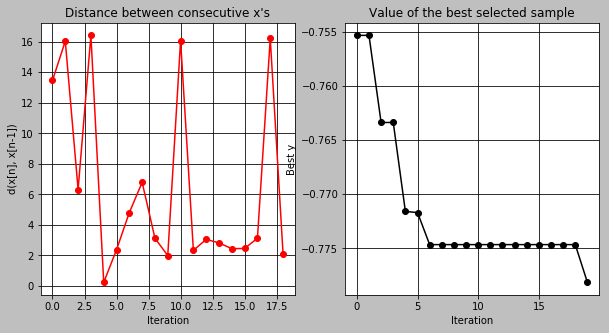

In [53]:
# Conduct bayesian optimization of xgboost classifier
optimizer_classify = bayesianOptimizer(cvClassifier, X, y, convergence_classifier)

In [54]:
# Display highest AUC score achieved
-np.amin(optimizer_classify.Y)

0.7781486973041554

In [55]:
# Select best set of parameters for the classifier
classifier_parameters = optimizer_classify.X[np.argmin(optimizer_classify.Y)]
# Display best parameters for the classifier
classifier_parameters

array([10.        ,  0.28122978, 20.        ,  1.36022267,  0.        ,
        0.        ,  0.5178201 ,  1.        ,  0.3       ,  3.89773608,
        7.29083864,  1.24594643])

#### 5.4.2. Regressor optimization

In [56]:
# Define the X and y data
X = presence_data[regressor_features]
y = presence_data[cover]
# Shuffle data
X, y = shuffle(X, y)

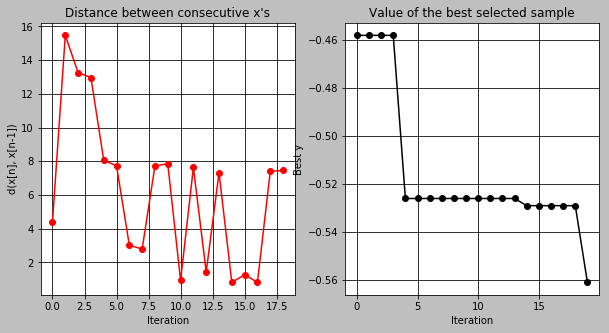

In [57]:
# Conduct bayesian optimization of xgboost regressor
optimizer_regress = bayesianOptimizer(cvRegressor, X, y, convergence_regressor)

In [58]:
# Display highest R Squared score achieved
-np.amin(optimizer_regress.Y)

0.5611358068687525

In [59]:
# Select best set of hyperparameters for the regressor
regressor_parameters = optimizer_regress.X[np.argmin(optimizer_regress.Y)]
# Display best hyperparameters for the regressor
regressor_parameters

array([10.        ,  0.20171823, 20.        ,  4.18508679,  0.        ,
        3.87464767,  0.7578919 ,  0.48670345,  0.61229838,  3.18630579,
        3.94939571,  4.00445794])

### 5.3. Train and Test Iterations (n=100)

In [60]:
# Create empty lists to store threshold and performance metrics
threshold_list = []
sensitivity_list = []
specificity_list = []
auc_list = []
accuracy_list = []
overall_r_score_list = []
overall_mae_list = []
overall_rmse_list = []
abundance_r_score_list = []
abundance_mae_list = []
abundance_rmse_list = []
# Create an empty data frame to store the test results
output_test = pd.DataFrame(columns=output_variables)
i = 1
while i < 101:
    # Set output display to show one message with replacement
    clear_output(wait=True)
    # Split the data into train and test partitions with equal representation of AIM and non-AIM data
    non_aim = input_data[input_data['project'] != 'AIM NPR-A']
    aim = input_data[input_data['project'] == 'AIM NPR-A']
    non_train, non_test = partitionData(non_aim, all_variables, predictor_all, zero_variable, strata)
    aim_train, aim_test = partitionData(aim, all_variables, predictor_all, zero_variable, strata)
    all_train = non_train.append(aim_train, ignore_index=True, sort=True)
    all_test = non_test.append(aim_test, ignore_index=True, sort=True)
    # Add the iteration count to the test data
    all_test['iteration'] = i
    # Train and predict a classifier
    all_test = trainPredictClassifier(all_train, all_test, classifier_features, zero_variable, classifier_parameters)
    # Subset the training data to presences from AIM NPR-A
    presence_train = all_train[all_train[cover[0]] >= 1]
    presence_train = presence_train[presence_train['project'] == 'AIM NPR-A']
    # Train and predict a regressor
    all_test = trainPredictRegressor(presence_train, all_test, regressor_features, cover, regressor_parameters)
    # Calculate the optimal threshold and performance of the presence-absence classification
    threshold, sensitivity, specificity, auc, accuracy = determineOptimalThreshold(all_test[presence[0]], all_test[zero_variable[0]])
    # Composite the classifier and regressor predictions
    all_test = compositePrediction(all_test, presence, response, threshold)
    # Subset the test data to AIM NPR-A
    aim_test = all_test[all_test['project'] == 'AIM NPR-A']
    # Calculate overall performance
    overall_r_score, overall_mae, overall_rmse = calculatePerformance(aim_test, cover, prediction)
    # Subset the aim test to presences
    aim_presences = aim_test[aim_test[cover[0]] >= 1]
    # Calculate abundance performance
    abundance_r_score, abundance_mae, abundance_rmse = calculatePerformance(aim_presences, cover, response)
    # Add threshold and performance metrics to list
    threshold_list.append(threshold)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    auc_list.append(auc)
    accuracy_list.append(accuracy)
    overall_r_score_list.append(overall_r_score)
    overall_mae_list.append(overall_mae)
    overall_rmse_list.append(overall_rmse)
    abundance_r_score_list.append(abundance_r_score)
    abundance_mae_list.append(abundance_mae)
    abundance_rmse_list.append(abundance_rmse)
    # Add the test results to output data frame
    output_test = output_test.append(all_test, ignore_index=True, sort=True)
    print('Model train-test iteration ' + str(i) + ' out of 100 completed...')
    # Increase the counter by 1
    i = i+1

Model train-test iteration 100 out of 100 completed...


### 5.4. Export Results

In [61]:
# Export test results to csv
output_test.to_csv(output_csv, header=True, index=False, sep=',', encoding='utf-8')

In [62]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plot.rcParams["figure.figsize"] = fig_size

In [63]:
# Export a Pearson Correlation plot for the predictor variables
plotVariableCorrelation(input_data[predictor_all], variable_correlation)

In [64]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 6
plot.rcParams["figure.figsize"] = fig_size

In [65]:
# Train and export a final classifier using the full input data
trainExportClassifier(input_data,
                      classifier_features,
                      zero_variable,
                      classifier_parameters,
                      output_classifier,
                      importance_classifier)

In [66]:
# Train and export a final regressor using the presence data from NPR-A AIM
trainExportRegressor(presence_data,
                     regressor_features,
                     cover,
                     regressor_parameters,
                     output_regressor,
                     importance_regressor)

In [67]:
# Calculate mean for threshold and all performance metrics
threshold_mean = np.mean(threshold_list)
sensitivity_mean = np.mean(sensitivity_list)
specificity_mean = np.mean(specificity_list)
auc_mean = np.mean(auc_list)
accuracy_mean = np.mean(accuracy_list)
overall_r_score_mean = np.mean(overall_r_score_list)
overall_mae_mean = np.mean(overall_mae_list)
overall_rmse_mean = np.mean(overall_rmse_list)
abundance_r_score_mean = np.mean(abundance_r_score_list)
abundance_mae_mean = np.mean(abundance_mae_list)
abundance_rmse_mean = np.mean(abundance_rmse_list)
# Calculate standard deviation for threshold and all performance metrics
threshold_sd = np.std(threshold_list)
sensitivity_sd = np.std(sensitivity_list)
specificity_sd = np.std(specificity_list)
auc_sd = np.std(auc_list)
accuracy_sd = np.std(accuracy_list)
overall_r_score_sd = np.std(overall_r_score_list)
overall_mae_sd = np.std(overall_mae_list)
overall_rmse_sd = np.std(overall_rmse_list)
abundance_r_score_sd = np.std(abundance_r_score_list)
abundance_mae_sd = np.std(abundance_mae_list)
abundance_rmse_sd = np.std(abundance_rmse_list)

In [68]:
# Export threshold and performance metrics as a table
metrics_dataframe = pd.DataFrame({'threshold':threshold_list,
                                  'sensitivity':sensitivity_list,
                                  'specificity':specificity_list,
                                  'auc':auc_list,
                                  'accuracy':accuracy_list,
                                  'overall_r_score':overall_r_score_list,
                                  'overall_mae':overall_mae_list,
                                  'overall_rmse':overall_rmse_list,
                                  'abundance_r_score':abundance_r_score_list,
                                  'abundance_mae':abundance_mae_list,
                                  'abundance_rmse':abundance_rmse_list})
metrics_dataframe.to_csv(metrics_file, header=True, index=False, sep=',', encoding='utf-8')

In [69]:
# Write a text file to store the presence-absence conversion threshold
file = open(threshold_file, 'w')
file.write(str(round(threshold_mean, 5)))
file.close()

In [70]:
# Write html text file
output_report = os.path.join(output_folder, output_report_name)
output_text = os.path.splitext(output_report)[0] + ".txt"
text_file = open(output_text, "w")
text_file.write("<html>\n")
text_file.write("<head>\n")
text_file.write("<meta http-equiv=\"pragma\" content=\"no-cache\">\n")
text_file.write("<meta http-equiv=\"Expires\" content=\"-1\">\n")
text_file.write("</head>\n")
text_file.write("<body>\n")
text_file.write("<div style=\"width:90%;max-width:1000px;margin-left:auto;margin-right:auto\">\n")
text_file.write("<h1 style=\"text-align:center;\">Distribution-abundance model performance for " + taxon_name + "</h1>\n")
text_file.write("<br>" + "\n")
text_file.write("<h2>Predicted Distribution-abundance Pattern</h2>\n")
text_file.write("<p>Distribution-abundance was predicted by a composite hierarchical model: 1. a classifier predicted species presence or absence, and 2. a regressor predicted species proportional abundance in areas where the classifier predicted the species is present. The map below shows the output raster prediction.</p>\n")
text_file.write("<p><i>Prediction step has not yet been performed. No output to display.</i></p>\n")
text_file.write("<h2>Recursive Feature Elimination</h2>\n")
text_file.write("<p>A total of 83 features were prepared for the modeling process. Given the individual responses of species to environmental gradients, the variation of each species distribution and abundance is likely best explained by species-specific feature combinations. Uninformative features are a potential source of noise in the models and retaining the uninformative features could result in reduced predictive performance. We selected the best performing set of features by recursive feature elimination based on the cross validation of ROC AUC for classification and R Squared for regression.</p>\n")
text_file.write("<h3>Classifier Feature Elimination</h3>\n")
text_file.write("<p>The optimal number of variables for the classifier was " + str(recursive_eliminator_classifier.n_features_) + ".</p>\n")
text_file.write("<a target='_blank' href='plots\\classifier_feature_elimination.png'><img style='display:inline-block;max-width:720px;width:100%;' src='plots\\classifier_feature_elimination.png'></a>\n")
text_file.write("<h3>Regressor Feature Elimination</h3>\n")
text_file.write("<p>The optimal number of variables for the regressor was " + str(recursive_eliminator_regressor.n_features_) + ".</p>\n")
text_file.write("<a target='_blank' href='plots\\regressor_feature_elimination.png'><img style='display:inline-block;max-width:720px;width:100%;' src='plots\\regressor_feature_elimination.png'></a>\n")
text_file.write("<h2>Bayesian Optimization of Hyperparameters</h2>\n")
text_file.write("<p>The hyperparameters of the classifier and regressor were independently optimized in a bayesian framework using a Gaussian Process as the generative model. Optimization performance was determined by 5-fold cross validation using area under the receiver operating characteristic curve (AUC) as the metric to maximize for the classifier and negative mean squared error (-MSE) as the metric to maximize for the regressor. 1000 optimization iterations were performed and the best set of parameters was selected based on the maximization criteria.</p>\n")
text_file.write("<h3>Classifier Optimization</h3>\n")
text_file.write("<p>The hyperparameters of the gradient boosting classifier (using the XGBoost implementation) were optimized to the following values:</p>\n")
text_file.write("<p>max_depth = " + str(int(classifier_parameters[0])) + "</p>\n")
text_file.write("<p>learning_rate = " + str(classifier_parameters[1]) + "</p>\n")
text_file.write("<p>n_estimators = " + str(int(classifier_parameters[2])) + "</p>\n")
text_file.write("<p>silent = True</p>" + "\n")
text_file.write("<p>objective = 'binary:logistic'</p>\n")
text_file.write("<p>booster = 'gbtree'</p>\n")
text_file.write("<p>n_jobs = 1</p>\n")
text_file.write("<p>gamma = " + str(classifier_parameters[3]) + "</p>\n")
text_file.write("<p>min_child_weight = " + str(int(classifier_parameters[4])) + "</p>\n")
text_file.write("<p>max_delta_step = " + str(int(classifier_parameters[5])) + "</p>\n")
text_file.write("<p>subsample = " + str(classifier_parameters[6]) + "</p>\n")
text_file.write("<p>colsample_bytree = " + str(classifier_parameters[7]) + "</p>\n")
text_file.write("<p>colsample_bylevel = " + str(classifier_parameters[8]) + "</p>\n")
text_file.write("<p>reg_alpha = " + str(classifier_parameters[9]) + "</p>\n")
text_file.write("<p>reg_lambda = " + str(classifier_parameters[10]) + "</p>\n")
text_file.write("<p>scale_pos_weight = " + str(classifier_parameters[11]) + "</p>\n")
text_file.write("<a target='_blank' href='plots\\convergence_classifier.png'><img style='display:inline-block;max-width:720px;width:100%;' src='plots\\convergence_classifier.png'></a>\n")
text_file.write("<h3>Regressor Optimization</h3>\n")
text_file.write("<p>The hyperparameters of the gradient boosting regressor (using the XGBoost implementation) were optimized to the following values:</p>\n")
text_file.write("<p>max_depth = " + str(int(regressor_parameters[0])) + "</p>\n")
text_file.write("<p>learning_rate = " + str(regressor_parameters[1]) + "</p>\n")
text_file.write("<p>n_estimators = " + str(int(regressor_parameters[2])) + "</p>\n")
text_file.write("<p>silent = True</p>\n")
text_file.write("<p>objective = 'reg:linear'</p>\n")
text_file.write("<p>booster = 'gbtree'</p>\n")
text_file.write("<p>n_jobs = 1</p>\n")
text_file.write("<p>gamma = " + str(regressor_parameters[3]) + "</p>\n")
text_file.write("<p>min_child_weight = " + str(int(regressor_parameters[4])) + "</p>\n")
text_file.write("<p>max_delta_step = " + str(int(regressor_parameters[5])) + "</p>\n")
text_file.write("<p>subsample = " + str(regressor_parameters[6]) + "</p>\n")
text_file.write("<p>colsample_bytree = " + str(regressor_parameters[7]) + "</p>\n")
text_file.write("<p>colsample_bylevel = " + str(regressor_parameters[8]) + "</p>\n")
text_file.write("<p>reg_alpha = " + str(regressor_parameters[9]) + "</p>\n")
text_file.write("<p>reg_lambda = " + str(regressor_parameters[10]) + "</p>\n")
text_file.write("<p>scale_pos_weight = " + str(regressor_parameters[11]) + "</p>\n")
text_file.write("<a target='_blank' href='plots\\convergence_regressor.png'><img style='display:inline-block;max-width:720px;width:100%;' src='plots\\convergence_regressor.png'></a>\n")
text_file.write("<h2>Composite Model Performance</h2>\n")
text_file.write("<p>Model performance was measured by pseudo r squared, mean absolute error, and root mean squared error for the composite prediction. Additionally, the performance of the absence class is reported as an area under the receiver operating characteristic curve (AUC) and overall accuracy, where specificity and sensitivity are as close to equal as possible (i.e, the model performs equally well at predicting absences and presences). All performance results are reported as the mean and standard deviation of the independent test predictions from 100 train-test splits. For each split, 30% of the data was withheld from model training and used as an independent test partition. The test partition was randomly selected from cover class strata: 0%, 1-10%, 11-25%, and 26-100%.</p>\n")
text_file.write("<h3>Overall Performance</h3>\n")
text_file.write("<p>R Squared = " + str(np.round(overall_r_score_mean, 2)) + " +/- " + str(np.round(overall_r_score_sd, 2)) +"</p>\n")
text_file.write("<p>Mean Absolute Error = " + str(np.round(overall_mae_mean, 2)) + " +/- " + str(np.round(overall_mae_sd, 2)) +"</p>\n")
text_file.write("<p>Root Mean Squared Error = " + str(np.round(overall_rmse_mean, 2)) + " +/- " + str(np.round(overall_rmse_sd, 2)) +"</p>\n")
text_file.write("<h3>Absence Performance</h3>\n")
text_file.write("<p>AUC = " + str(np.round(auc_mean, 2)) + " +/- " + str(np.round(auc_sd, 2)) +"</p>\n")
text_file.write("<p>Presence-Absence Accuracy = " + str(np.round(accuracy_mean, 2)) + " +/- " + str(np.round(accuracy_sd, 2)) +"</p>\n")
text_file.write("<h3>Abundance Performance</h3>\n")
text_file.write("<p>R Squared = " + str(np.round(abundance_r_score_mean, 2)) + " +/- " + str(np.round(abundance_r_score_sd, 2)) +"</p>\n")
text_file.write("<p>Mean Absolute Error = " + str(np.round(abundance_mae_mean, 2)) + " +/- " + str(np.round(abundance_mae_sd, 2)) +"</p>\n")
text_file.write("<p>Root Mean Squared Error = " + str(np.round(abundance_rmse_mean, 2)) + " +/- " + str(np.round(abundance_rmse_sd, 2)) +"</p>\n")
text_file.write("<h3>Classifier Importances</h3>\n")
text_file.write("<p>The Variable Importance plot for the classifier is shown below:</p>\n")
text_file.write("<a target='_blank' href='plots\\importance_classifier.png'><img style='display:inline-block;max-width:1000px;width:100%;' src='plots\\importance_classifier.png'></a>\n")
text_file.write("<h3>Regressor Importances</h3>\n")
text_file.write("<p>The Variable Importance plot for the regressor is shown below:</p>\n")
text_file.write("<a target='_blank' href='plots\\importance_regressor.png'><img style='display:inline-block;max-width:1000px;width:100%;' src='plots\\importance_regressor.png'></a>\n")
text_file.write(r"<h2>Variable Correlation</h2>" + "\n")
text_file.write("<p>The plot below explores variable correlation. No attempt was made to remove highly correlated variables (shown in the plot dark blue).</p>\n")
text_file.write("<a target='_blank' href='plots\\variable_correlation.png'><img style='display:inline-block;width:100%;' src='plots\\variable_correlation.png'></a>\n")
text_file.write("</div>\n")
text_file.write("</body>\n")
text_file.write("</html>\n")
text_file.close()

In [71]:
# Rename HTML Text to HTML
if os.path.exists(output_report) == True:
    os.remove(output_report)
os.rename(output_text, output_report)